In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import numpy as np
import sklearn, sklearn.model_selection
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.manual_seed(1);

In [3]:
cuda = torch.cuda.is_available()

In [4]:
BATCH_SIZE = 64

In [5]:
from torch.utils import data
import os
import skimage, skimage.transform
from skimage.io import imread, imsave

In [25]:
from PIL import Image


In [292]:
class TNTDataset(data.Dataset):
    'Tumor-NoTumor Dataset loader for PyTorch'
    def __init__(self, tntpath, subset="train", transform=None):
        self.tntpath = tntpath
        self.subset = subset
        self.datapath = self.tntpath + "/" + self.subset + "/"
        self.imgs = sorted(os.listdir(self.datapath + "/flair"))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, index):
        # Select sample
        filename = self.imgs[index]
        
        flair = imread(self.datapath + "/flair/" + filename)
        flair = Image.fromarray(flair)
        if self.transform != None:
            flair = self.transform(flair)
            
        t1 = imread(self.datapath + "/t1/" + filename)
        t1 = Image.fromarray(t1)
        if self.transform != None:
            t1 = self.transform(t1)
            
        seg = imread(self.datapath + "/segmentation/" + filename)
        seg = ((seg >= 30))*256.
        seg = Image.fromarray(seg)
        if self.transform != None:
            seg = self.transform(seg)
            
        seg = seg > 0
        
        has_tumor = ("True" in filename)

        return (flair, t1, seg), has_tumor 

In [293]:
mytransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(100),
    torchvision.transforms.ToTensor()])

In [294]:
train = TNTDataset("/data/lisa/data/brats2013_tumor-notumor/", transform=mytransform)

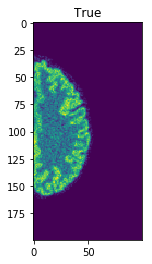

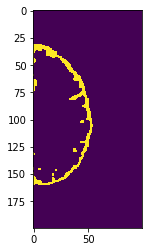

In [295]:
plt.imshow(train[5][0][0][0]);
plt.title(train[5][1]);
plt.show()
plt.imshow(train[5][0][2][0]);

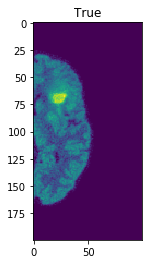

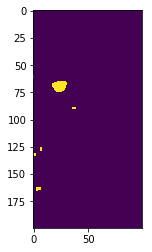

In [296]:
plt.imshow(train[250][0][0][0]);
plt.title(train[250][1]);
plt.show()
plt.imshow(train[250][0][2][0]);

In [297]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

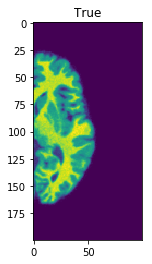

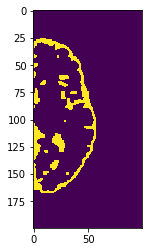

In [298]:
def f(x):
    plt.imshow(train[x][0][1][0]);
    plt.title(train[x][1]);
    plt.show()
    plt.imshow(train[x][0][2][0]);

interact(f, x=(0,len(train),1));

In [149]:
tosplit = np.asarray([("True" in name) for name in train.imgs])
idx = range(tosplit.shape[0])
train_idx, valid_idx = sklearn.model_selection.train_test_split(idx, stratify=tosplit, train_size=0.75, random_state=0)


/u/cohenjos/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [150]:
print "train_idx", len(train_idx)
print "valid_idx", len(valid_idx)

train_idx 1593
valid_idx 532


In [151]:
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(train_idx))
valid_loader = torch.utils.data.DataLoader(dataset=train, batch_size=len(valid_idx), 
                                          sampler=torch.utils.data.sampler.SubsetRandomSampler(valid_idx))

In [152]:
valid_data = list(valid_loader)
valid_x = Variable(valid_data[0][0][0]).cuda()
valid_y = valid_data[0][1].cuda()

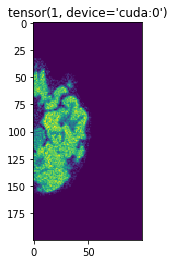

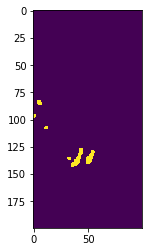

In [300]:
plt.imshow(valid_data[0][0][0][60][0]);
plt.title(valid_y[60]);
plt.show()
plt.imshow(valid_data[0][0][2][60][0]);


In [301]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),     
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=32,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=16,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=16,
                out_channels=8,
                kernel_size=3,
                stride=2,   
                padding=0,        
            ),
            nn.ReLU(),
        )
        self.out = nn.Linear(440, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

In [175]:
cnn = CNN()
if cuda:
    cnn = cnn.cuda()

print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
  )
  (out): Linear(in_features=440, out_features=2, bias=True)
)


In [176]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [322]:
# plt.imshow(x[1][62][0])

In [309]:
for epoch in range(200):
    batch_loss = []
    for step, (x, y) in enumerate(train_loader):
        
        b_x = Variable(x[0], requires_grad=True)
        b_y = Variable(y)
        
        if cuda:
            b_x = b_x.cuda()
            b_y = b_y.cuda()

        cnn.train()
        output = cnn(b_x)[0]
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.data[0])
        #print loss.data[0]
    
    cnn.eval()
    test_output, last_layer = cnn(valid_x)
    pred_y = torch.max(test_output, 1)[1].data.squeeze()
    accuracy = float(sum(pred_y == valid_y.cuda())) / float(valid_y.size(0))
    print('Epoch: ', epoch, '| train loss: %.4f' % np.asarray(batch_loss).mean(), '| valid accuracy: %.2f' % accuracy)

/part/01/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


KeyboardInterrupt: 

In [ ]:
x, y = train[250]

In [338]:
x[0].shape

torch.Size([1, 200, 100])

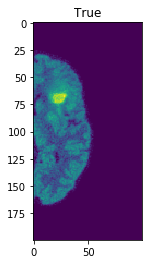

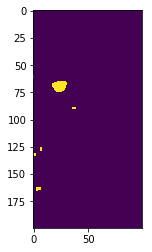

In [339]:
plt.imshow(x[0][0]);
plt.title(y);
plt.show()
plt.imshow(x[2][0]);

In [343]:
a = x[0]

In [348]:
x_var = Variable(x[0].unsqueeze(0).cuda(), requires_grad=True)
pred = cnn(x_var)

In [359]:
test = torch.autograd.grad(outputs=torch.abs(pred[0]).sum(), 
                                       inputs=x_var, 
                                       retain_graph=True, 
                                       create_graph=True,
                                       grad_outputs=torch.FloatTensor([1]).cuda())

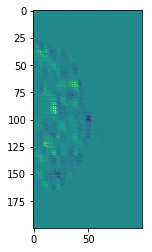

In [360]:
plt.imshow(test[0][0][0].cpu().detach().numpy());

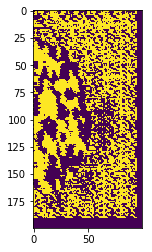

In [361]:
# So much gradient!
plt.imshow(test[0][0][0].cpu().detach().numpy()>0.0000001);

In [ ]:
#torch.save(cnn.state_dict(), "./classifier_model.pth")

In [18]:
checkpoint = torch.load("./classifier_model.pth")
cnn.load_state_dict(checkpoint)

In [43]:
cnn.eval()
test_output, last_layer = cnn(valid_x)
pred_y = torch.max(test_output, 1)[1].data.squeeze()
accuracy = float((pred_y == valid_y).sum()) / float(valid_y.size(0))
print 'valid accuracy: %.2f' % accuracy

valid accuracy: 0.82


In [44]:
class SubsetSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):

        return len(self.indices)


In [45]:
import collections

In [46]:
results = []

for percent in ["0.0", 
                "0.1", 
                "0.2", 
                "0.3", 
                "0.4", 
                "0.5", 
                "0.6", 
                "0.7", 
                "0.8", 
                "0.9", 
                "1.0"]:
    
    path = "./cyclegan/results/brats2013_cyclegan_" + percent + "/test_latest/"
    test_data_raw = torchvision.datasets.ImageFolder(path, transform=mytransform)
    
    labels = np.asarray(["True" in img for img in np.asarray(test_data_raw.imgs)[:,0]])
    fake_b_samples = np.where(["fake_B" in img for img in np.asarray(test_data_raw.imgs)[:,0]])[0]
    real_b_samples = np.where(["real_B" in img for img in np.asarray(test_data_raw.imgs)[:,0]])[0]

    test_fake_b_loader = torch.utils.data.DataLoader(dataset=test_data_raw, batch_size=len(test_data_raw), shuffle=False, 
                                              sampler=SubsetSampler(fake_b_samples))
    
    test_fake_b_data = list(test_fake_b_loader)
    test_fake_b_x = Variable(test_fake_b_data[0][0])
    test_fake_b_y = test_fake_b_data[0][1]
    
    cnn.eval()
    r = cnn(test_fake_b_x)

    pred_y = torch.max(r[0], 1)[1].data.squeeze().numpy()
    
    acc = (pred_y == labels[fake_b_samples]).mean()
    
    dist_0 = pred_y[labels[fake_b_samples] == 0].mean()
    dist_1 = pred_y[labels[fake_b_samples] == 1].mean()

    results.append([percent, pred_y.mean(), acc, dist_0, dist_1, collections.Counter(pred_y)])
    
    print "Percent:", percent," Tumors:", pred_y.mean(), " ", collections.Counter(pred_y)

Percent: 0.0  Tumors: 0.2857142857142857   Counter({0: 215, 1: 86})
Percent: 0.1  Tumors: 0.32558139534883723   Counter({0: 203, 1: 98})


KeyboardInterrupt: 

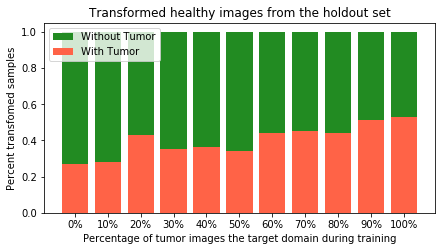

In [29]:
plt.rcParams['figure.figsize'] = (7, 3.5)
perc = np.asarray(results)[:,3].astype(np.float)
plt.bar(range(perc.shape[0]), 1-perc, bottom=perc,color="forestgreen", label="Without Tumor");
plt.bar(range(perc.shape[0]), perc, color="tomato", label="With Tumor");
plt.ylabel("Percent transfomed samples")
plt.xlabel("Percentage of tumor images the target domain during training");
plt.xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
plt.title("Transformed healthy images from the holdout set"); # (GT=False)
plt.legend(loc="upper left");

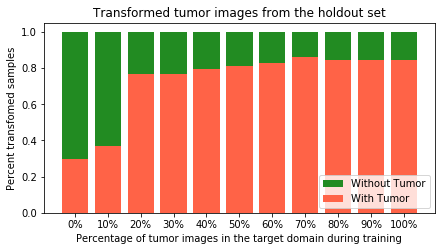

In [30]:
plt.rcParams['figure.figsize'] = (7, 3.5)
perc = np.asarray(results)[:,4].astype(np.float)
plt.bar(range(perc.shape[0]), 1-perc, bottom=perc,color="forestgreen", label="Without Tumor");
plt.bar(range(perc.shape[0]), perc, color="tomato", label="With Tumor");
plt.ylabel("Percent transfomed samples")
plt.xlabel("Percentage of tumor images in the target domain during training");
plt.xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
plt.title("Transformed tumor images from the holdout set"); # (GT=False)
plt.legend(loc="lower right");

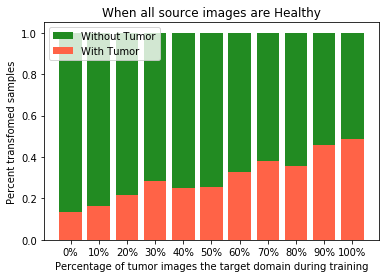

In [692]:
perc = np.asarray(results)[:,3].astype(np.float)
plt.bar(range(perc.shape[0]), 1-perc, bottom=perc,color="forestgreen", label="Without Tumor");
plt.bar(range(perc.shape[0]), perc, color="tomato", label="With Tumor");
plt.ylabel("Percent transfomed samples")
plt.xlabel("Percentage of tumor images the target domain during training");
plt.xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
plt.title("When all source images are Healthy"); # (GT=False)
plt.legend(loc="upper left")

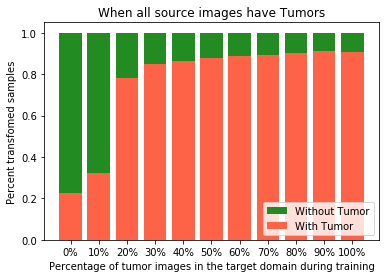

In [693]:
perc = np.asarray(results)[:,4].astype(np.float)
plt.bar(range(perc.shape[0]), 1-perc, bottom=perc,color="forestgreen", label="Without Tumor");
plt.bar(range(perc.shape[0]), perc, color="tomato", label="With Tumor");
plt.ylabel("Percent transfomed samples")
plt.xlabel("Percentage of tumor images in the target domain during training");
plt.xticks(range(11), ["0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%"])
plt.title("When all source images have Tumors"); # (GT=False)
plt.legend(loc="lower right")

In [695]:
torch.save(cnn.state_dict(), "./classifier_model.pth")